# Ways to win Jeopardy

In this project, we would like to figure out some patterns in the questions of Jeopardy that could help us to win in Jeopardy. The dataset we used is available [here](https://www.reddit.com/r/datasets/comments/1uyd0t/200000_jeopardy_questions_in_a_json_file). This dataset contains 20000 rows from the beginning of a full dataset of Jeopardy questions.

In [1]:
import pandas as pd
import numpy as np
import re
from scipy.stats import chisquare
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
jeopardy = pd.read_csv('jeopardy.csv')
jeopardy.head(3)

,Show Number,Air Date,Round,Category,Value,Question,Answer
0,4680,2004-12-31,Jeopardy!,HISTORY,$200,"For the last 8 years of his life, Galileo was ...",Copernicus
1,4680,2004-12-31,Jeopardy!,ESPN's TOP 10 ALL-TIME ATHLETES,$200,No. 2: 1912 Olympian; football star at Carlisl...,Jim Thorpe
2,4680,2004-12-31,Jeopardy!,EVERYBODY TALKS ABOUT IT...,$200,The city of Yuma in this state has a record av...,Arizona


In [3]:
jeopardy.columns

Index(['Show Number', ' Air Date', ' Round', ' Category', ' Value',
       ' Question', ' Answer'],
      dtype='object')

Some column names has unnecessary white space we need to remove.

In [4]:
# remove white space in column names
jeopardy.columns = jeopardy.columns.str.strip()

In [5]:
jeopardy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19999 entries, 0 to 19998
Data columns (total 7 columns):
Show Number    19999 non-null int64
Air Date       19999 non-null object
Round          19999 non-null object
Category       19999 non-null object
Value          19999 non-null object
Question       19999 non-null object
Answer         19999 non-null object
dtypes: int64(1), object(6)
memory usage: 1.1+ MB


The next step will be normalizing all the text in `Question` and `Answer` columns. Some types of columns should also be modified into a correct type. For example, `Value` should be **int** and `Air Date` should be **Date**.

In [6]:
# remove punctuation and convert text into lowercase
def normalize_text(string):
    new_string = string.lower()
    new_string = re.sub(r'[^\w\s]','', new_string)
    return new_string

In [7]:
# normalizing `Question` and `Answer`
jeopardy['clean_question'] = jeopardy['Question'].apply(normalize_text)
jeopardy['clean_answer'] = jeopardy['Answer'].apply(normalize_text)

In [8]:
# remove all punctuation and set charater string as 0
def normalize_value(string):
    new_string = re.sub(r'[^\w]','', string)
    try:
        new_string = int(new_string)
    except ValueError:
        new_string = int(0)
    return new_string

In [9]:
# normalizing `Value`
jeopardy['clean_value'] = jeopardy['Value'].apply(normalize_value)

In [10]:
# normalizing `Air Date`
jeopardy['Air Date'] = pd.to_datetime(jeopardy['Air Date'])

In order to figure out whether to study past questions, study general knowledge, or not study it all, it would be helpful to figure out two things:

1. How often the answer is deducible from the question.
2. How often new questions are repeats of older questions.

The first question can be found out by seeing how many times words in the answer also occur in the question, while the second question can be answered by seeing how often complex words (> 6 characters) reoccur.

## 1. Number of times words in the answer occur in the question

In [11]:
def deducible(row):
    split_answer = row['clean_answer'].split()
    split_question = row['clean_question'].split()
    match_count = 0
    
    # exclude common word 'the'
    if 'the' in split_answer:
        split_answer.remove('the')
    
    # return 0 if answer is provided
    if len(split_answer) == 0:
        return 0
    
    # count repeated words in question
    for word in split_answer: 
        if word in split_question:
            match_count += 1 
    
    # return repeated word ratio
    return match_count/len(split_answer)

In [12]:
jeopardy['answer_in_question'] = jeopardy.apply(deducible, axis=1)
jeopardy['answer_in_question'].mean()

0.059001965249777744

In [13]:
jeopardy['answer_in_question'].value_counts(normalize=True).head(5)

0.000000    0.873794
0.500000    0.072404
0.333333    0.024701
0.250000    0.007750
1.000000    0.006200
Name: answer_in_question, dtype: float64

More than 10% of answers contain the words in the question and most of them repeat more than 1/3 of the words in the answers. 

## 2. Repeated complex words in new questions

In [14]:
# question_overlap = []
terms_used = []
question_overlap = []

jeopardy = jeopardy.sort_values(['Air Date']).reset_index(drop=True)

for index, row in jeopardy.iterrows():
    split_question = row['clean_question'].split()
    split_question = [word for word in split_question if len(word)>=6]
    match_count = 0
    for word in split_question:
        if word in terms_used:
            match_count += 1
        else: 
            terms_used.append(word)
    if len(split_question) > 0:
        question_overlap.append(match_count / len(split_question))
    else:
        question_overlap.append(0)

jeopardy['question_overlap'] = pd.Series(question_overlap)
print('The mean of questions overlap is {}.'.format(jeopardy['question_overlap'].mean()))

The mean of questions overlap is 0.6894006357823155.


Almost 69% of the complex words with at least 6 characters repeated in the new questions. It means we can take advantage of studying the aspect of the complex words with a high frequency of occurrence.

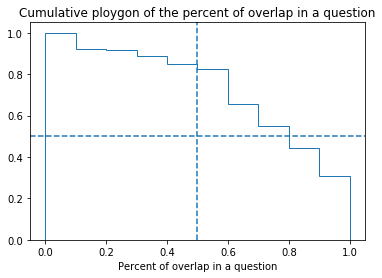

In [15]:
plt.hist(jeopardy['question_overlap'], density= True, cumulative=-1, histtype='step')
plt.xlabel('Percent of overlap in a question')
plt.title('Cumulative ploygon of the percent of overlap in a question')
plt.axvline(x=0.5, ls='--')
plt.axhline(y=0.5, ls='--')

From the above plot, almost 80% of questions have more than half of overlapped words, and 40% of questions have more than 80% of overlap. Moreover, around 30% of the questions occur once before. It means studying the old questions would help a lot to win in "Jeopardy".

## Study strategy

Since the questions have different values, we can optimize our effort to focus on the specific fields, which have a higher probablitiy to occur in the higher value questions. We assume questions with a value more than 800 as high value questions. Then we will find the words occur more frequently in the high value questions.

In [16]:
# classify high value questions
def value_cat(row):
    if row['clean_value'] > 800:
        value = 1
    else: 
        value = 0
    return value     

In [17]:
# classify question into high value or not
jeopardy['high_value'] = jeopardy.apply(value_cat, axis = 1)

In [18]:
# count the number of time a word occurs in high and low value questions
def word_value(word):
    low_count = 0
    high_count = 0
    for index, row in jeopardy.iterrows():
        text = row['clean_question'].split()
        if word in text:
            if row['high_value'] == 1:
                high_count += 1
            else: low_count += 1
    return high_count, low_count

Let's see which complex words (more than 6 characters) occur the most among all the questions.

In [19]:
all_words = {}
for cell in jeopardy['clean_question']:
    question = cell.split()
    for word in question:
        if len(word) > 6:
            if word in all_words:
                all_words[word] += 1
            else: 
                all_words[word] = 1
                
# Top 30 complex words occur in the questions
sorted(all_words.items(), key=lambda x: x[1], reverse=True)[:30]

[('country', 476),
 ('president', 258),
 ('american', 257),
 ('capital', 257),
 ('target_blankherea', 244),
 ('national', 183),
 ('largest', 179),
 ('british', 166),
 ('meaning', 162),
 ('century', 159),
 ('musical', 153),
 ('company', 151),
 ('between', 145),
 ('character', 141),
 ('founded', 141),
 ('reports', 141),
 ('target_blankthisa', 140),
 ('include', 138),
 ('million', 129),
 ('popular', 119),
 ('because', 111),
 ('through', 104),
 ('classic', 103),
 ('italian', 99),
 ('america', 97),
 ('another', 97),
 ('william', 96),
 ('english', 95),
 ('countrys', 93),
 ('created', 92)]

*country*, *president*, *american*, *capital*, *national*, *largest*, *british*, *century*, *musical* and *classic* are 10 of the most meaningful words. We will test their occurrence among high and low-value questions. If any words occur more in high-value questions significantly, we can focus on those aspects to improve our efficiency.

In [20]:
comparison_terms = ['country', 'president', 'american', 'capital', 'national',
                    'largest', 'british', 'century', 'musical', 'classic']
observed_expected = []

# count the frequency of a word occurs in high and low value questions
for word in comparison_terms:
    observed_expected.append(word_value(word))

In [21]:
word_list = pd.DataFrame(observed_expected,
                         columns = ['high_count', 'low_count'],
                         index = comparison_terms)
word_list

,high_count,low_count
country,141,332
president,68,181
american,77,174
capital,61,186
national,55,124
largest,42,134
british,54,110
century,54,102
musical,42,110
classic,31,72


To determine if the occurrence of a word has a significant difference, we use the Chi-square test to compare their expected and actual occurrence.

In [22]:
high_value_count = jeopardy['high_value'].sum()
low_value_count = len(jeopardy) - high_value_count

chi_squared = []
p_value = []

for word in observed_expected:
    total = np.sum(word)
    total_prop = total/len(jeopardy)
    expected_high_value_rows = total_prop*high_value_count
    expected_low_value_rows = total_prop*low_value_count
    observed = word
    expected = [expected_high_value_rows, expected_low_value_rows]
    chisq_value, pvalue = chisquare(observed, expected)
    chi_squared.append(chisq_value)
    p_value.append(pvalue)

In [23]:
word_list['chi_squared'] = chi_squared
word_list['p_value'] = p_value
word_list['high:low'] = round(word_list['high_count']/word_list['low_count'],2)
word_list

,high_count,low_count,chi_squared,p_value,high:low
country,141,332,0.299678,0.584084,0.42
president,68,181,0.225926,0.634561,0.38
american,77,174,0.493811,0.482232,0.44
capital,61,186,1.908425,0.167138,0.33
national,55,124,0.369564,0.543242,0.44
largest,42,134,1.989262,0.158418,0.31
british,54,110,1.452148,0.228184,0.49
century,54,102,2.695021,0.100662,0.53
musical,42,110,0.080367,0.776801,0.38
classic,31,72,0.102365,0.749010,0.43


The words *capital*, *largest* and *century* have a relatively significant difference (p-value < 0.2) with the expected occurrence than the other words. Considering that most of the words have a much higher chance to occur in low-value questions compared to high-value questions, *century* trends to have a higher chance to occur in high-value questions. It gives us an insight that we studying *century* related questions would help us to succeed in high-value question.

## Summary

Below are the findings in this project such that we can take advantages of winning Jeopardy:

1. around 10% answer occurs in the question.
2. 30% of questions are completely repeated, so study old questions would help a lot.
3. the word *century* is more likely to occur in high-value questions.